# Pré-processamento --= Spider-sense =--

## Algoritmos para correlação de atributos

### Importando bibliotecas e módulos para o pré-processamento

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Importando arquivo como variável array

In [ ]:
df_spider_sense = pd.read_csv("datasets/Spider-sense_3k_samples.csv")
np_spider_sense = df_spider_sense.to_numpy()

### Análise Exploratória de Dados (EDA)

In [3]:
#Observando os dados
print(df_spider_sense.shape, "\n")
print(df_spider_sense.head(1), "\n")
#print(df_spider_sense.columns, "\n")
print(df_spider_sense.describe(), "\n")

(3000, 114) 

      seq                timestamp  rssi  sig_mode  mcs  smoothing  \
0  158696  2024-04-10 23:59:31.831   -53         1    7          1   

   not_sounding  stbc  sgi  local_timestamp  ...    fase44    fase45  \
0             1     1    1       1443162925  ... -1.983207 -1.856848   

     fase46    fase47    fase48    fase49    fase50    fase51   fase52  \
0 -1.727398 -1.670465 -1.670465 -1.719686 -1.727398 -1.815775 -1.91382   

    rotulo  
0  sucesso  

[1 rows x 114 columns] 

                 seq         rssi     sig_mode          mcs    smoothing  \
count    3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean   216562.833333   -55.700000     0.912000     6.377000     0.912000   
std    113893.757371     3.557089     0.283342     1.982973     0.283342   
min     61437.000000   -61.000000     0.000000     0.000000     0.000000   
25%    158945.750000   -60.000000     1.000000     7.000000     1.000000   
50%    174492.500000   -54.000000     1.000

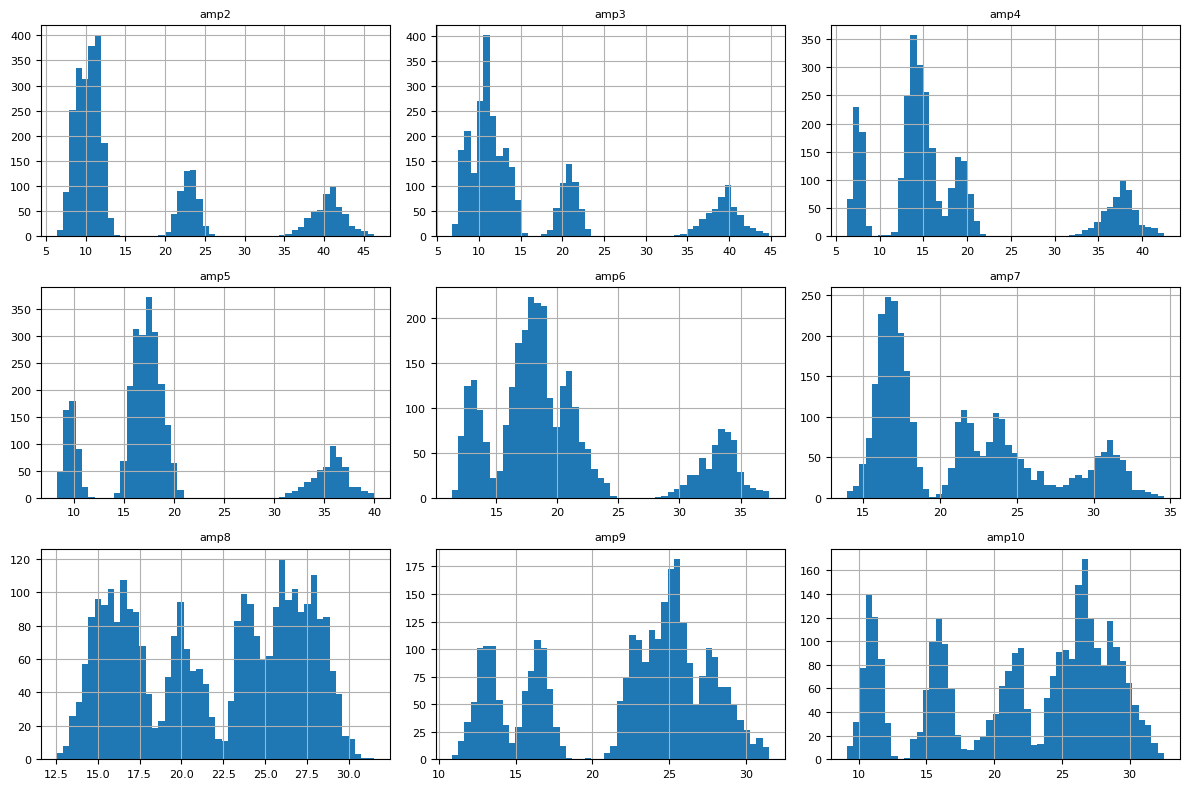

In [5]:
#Plotando graficamente os dados
df_spider_sense.iloc[:, 11:20].hist(bins=50, figsize=(12,8))
#Para ajustar os títulos e rótulos de cada eixo (se houver)
for ax in plt.gcf().axes:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.title.set_fontsize(8)

plt.tight_layout()
plt.show()

#### Algoritmos de correlação de atributos

- Pearson Correlation (atributos numéricos):  

    Encontra o relacionamento linear dos atributos ideal para classificação binária (0_1, A_B).

Correlação de Pearson entre atributos e classe alvo:
Top 9 atributos mais positivamente correlacionados com 'rotulo': 
 amp33    0.604909
amp32    0.602309
amp34    0.587559
amp31    0.579018
amp35    0.540989
amp30    0.526696
amp23   -0.469473
amp22   -0.464309
amp5    -0.463172
Name: rotulo, dtype: float64 

['amp33', 'amp32', 'amp34', 'amp31', 'amp35', 'amp30', 'amp23', 'amp22', 'amp5']


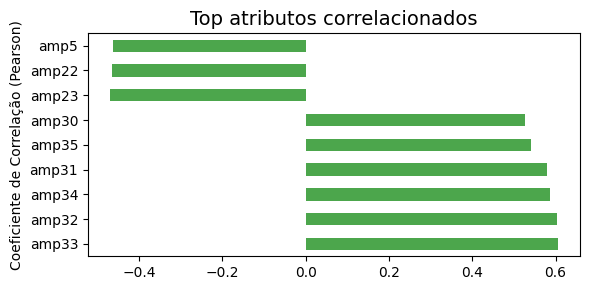

       amp2       amp3       amp4       amp5       amp6       amp7       amp8  \
0  7.643685  10.175536  13.840606  17.359214  20.827435  23.991450  26.553730   
1  7.303320   9.403840  12.473337  15.931253  19.546807  22.732262  25.421260   
2  7.964507   9.977793  13.201125  17.379283  21.042398  23.980153  26.643602   
3  8.537587  10.769880  13.832059  17.861577  21.754911  24.236354  26.744954   
4  7.542970   9.665575  12.939322  16.599770  20.222136  22.694273  24.819192   

        amp9      amp10      amp11  ...      amp43      amp44      amp45  \
0  28.429746  29.586716  29.405877  ...  16.623440  17.247475  17.975682   
1  27.220114  28.189803  28.373348  ...  16.462717  17.232518  17.485032   
2  28.459276  29.704258  30.584457  ...  16.797184  17.781135  18.460691   
3  28.263937  29.790275  30.787006  ...  17.162385  18.147238  19.307568   
4  26.697863  28.127565  28.807382  ...  16.066763  16.901437  18.415839   

       amp46      amp47      amp48      amp49      amp50

In [ ]:
#Selecionando as colunas de atributos (amplitudes)
atributos = df_spider_sense.iloc[:, 11:61]

#Selecionando a coluna alvo ('rotulo')
rotulo = df_spider_sense.iloc[:, 113].map({"falha": 0, "sucesso": 1})

# Concatenando atributos + alvo
df_corr = pd.concat([atributos, rotulo.rename("rotulo")], axis=1)

#Calculando correlação de Pearson entre cada atributo e a classe alvo ('rotulo')
correlations = df_corr.corr(method='pearson')['rotulo'].drop('rotulo')

#Top 9 maiores correlações positivas e negativas
top9_pos = correlations.sort_values(key=abs, ascending=False).head(9)
#top9_neg = correlations.sort_values(key=abs, ascending=True).head(9)

print("Correlação de Pearson entre atributos e classe alvo:")
print("Top 9 atributos mais positivamente correlacionados com 'rotulo':", '\n', top9_pos, '\n',)
#print("Top 9 atributos mais negativamente correlacionados com 'rotulo':", '\n', top9_neg)

#Selecionando os atributos mais correlacionados com classe alvo ('rotulo')
att_pearson_corr = top9_pos.index.tolist() #+ top9_neg.index.tolist()
print(att_pearson_corr)

#===============================================
#Plotando as 9 maiores correlações positivas
plt.figure(figsize=(6,3))
top9_pos.plot(kind='barh', color='green', alpha=0.7, label="Positiva")

#Plotando as 9 maiores correlações negativas
#top9_neg.plot(kind='barh', color='red', alpha=0.7, label="Negativa")

plt.title("Top atributos correlacionados", fontsize=14)
plt.ylabel("Coeficiente de Correlação (Pearson)")
plt.tight_layout()
plt.show()

- Random Forest (atributos numéricos):  

    Encontra relações complexas e não-lineares entre o astributos


Importância dos atributos segundo o Random Forest:
amp31    0.074064
amp35    0.069165
amp34    0.069073
amp48    0.068085
amp33    0.066043
amp30    0.063420
amp46    0.054293
amp47    0.053934
amp32    0.049737
dtype: float64
['amp31', 'amp35', 'amp34', 'amp48', 'amp33', 'amp30', 'amp46', 'amp47', 'amp32']


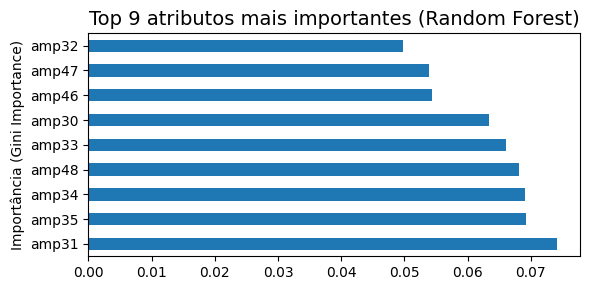

In [14]:
#Preparação dos dados (é necessário para o algoritmo Random Forest)
X = df_corr.drop(columns=['rotulo'])      #Apenas atributos sem classe alvo
y = df_corr['rotulo']                     #Classe alvo

#Divisão dos dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#======================
#Modelo Random Forest
rf = RandomForestClassifier(
    n_estimators=235,        #número de árvores
    max_depth=20,            #profundidade ilimitada
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

#Ordenação dos atributos pela importância
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

print("\nImportância dos atributos segundo o Random Forest:")
print(importances_sorted.head(9))  #mostra os 9 mais importantes

att_RF_corr = importances_sorted.head(9).index.tolist()
print(att_RF_corr)

plt.figure(figsize=(6,3))
importances_sorted.head(9).plot(kind='barh')
plt.title("Top 9 atributos mais importantes (Random Forest)", fontsize=14)
plt.ylabel("Importância (Gini Importance)")
plt.tight_layout()
plt.show()

#### Atributos com grande correlação com a classe alvo

In [15]:
best_att = []
for i in range(9):
    for j in range(9):
        if att_pearson_corr[i] == att_RF_corr[j]:
            best_att.append(att_pearson_corr[i])
            

print(best_att)

['amp33', 'amp32', 'amp34', 'amp31', 'amp35', 'amp30']


#### PairPlot da distribuição dos melhores atributos

       amp33      amp32      amp34      amp31      amp35      amp30   Rotulo
0  27.908109  25.856925  29.900920  22.555573  30.706497  18.494341  sucesso
1  27.931176  25.879325  29.686792  22.437266  30.445719  18.875093  sucesso
2  29.244921  27.173558  31.288166  23.606384  31.460959  19.848465  sucesso
3  29.928625  28.227017  32.062305  24.705798  31.995377  20.509192  sucesso
4  29.040501  27.068555  30.408620  23.859553  30.290360  19.520416  sucesso


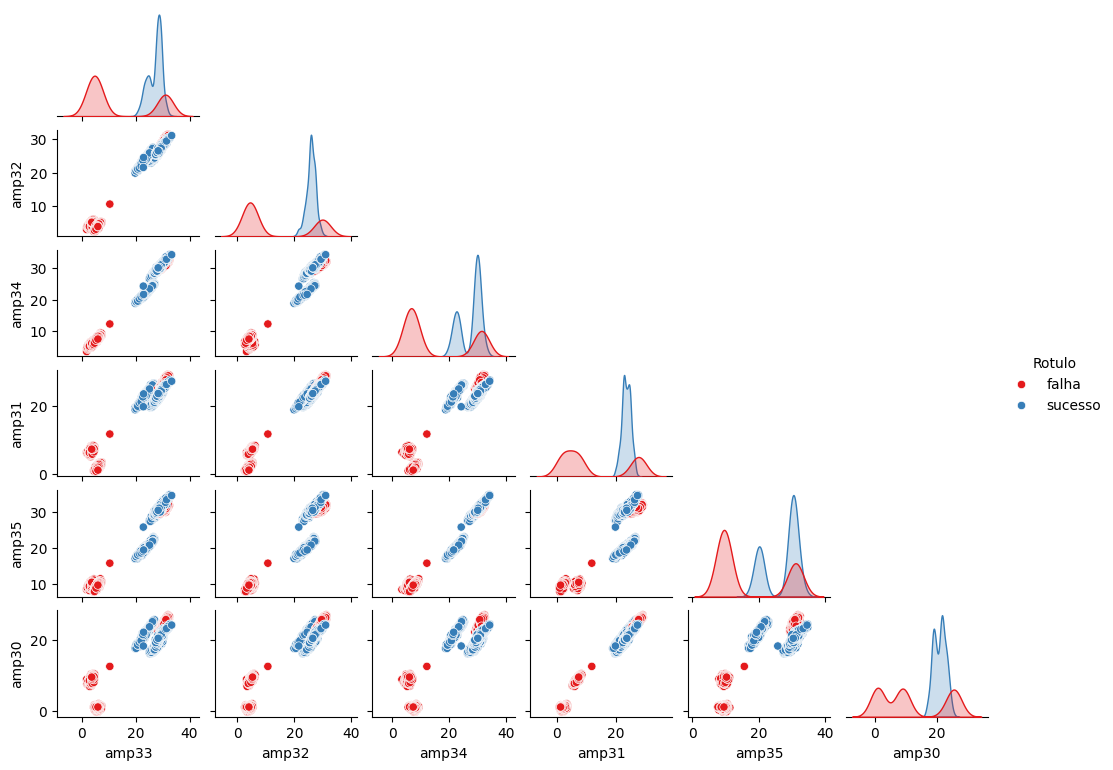

In [17]:
#Cria um novo DataFrame contendo os melhores atributos e a coluna de 'rotulo'
df_plot = df_corr[best_att + ['rotulo']].copy()

#Renomear a coluna e mapear os valores para falha = 0, sucesso = 1
df_plot = df_plot.rename(columns={'rotulo': 'Rotulo'})
df_plot['Rotulo'] = df_plot['Rotulo'].map({0: 'falha', 1: 'sucesso'})

print(df_plot.head())

#Cria um gráfico de dispersão múltipla entre entre os atributos e a classe alvo
plot = sns.pairplot(df_plot, hue='Rotulo', hue_order=['falha', 'sucesso'], palette='Set1', corner=True, height=1.3, aspect=1.3)
plt.show()

#### Visualizando a Função de Distribuição Cumulativa (CDF)

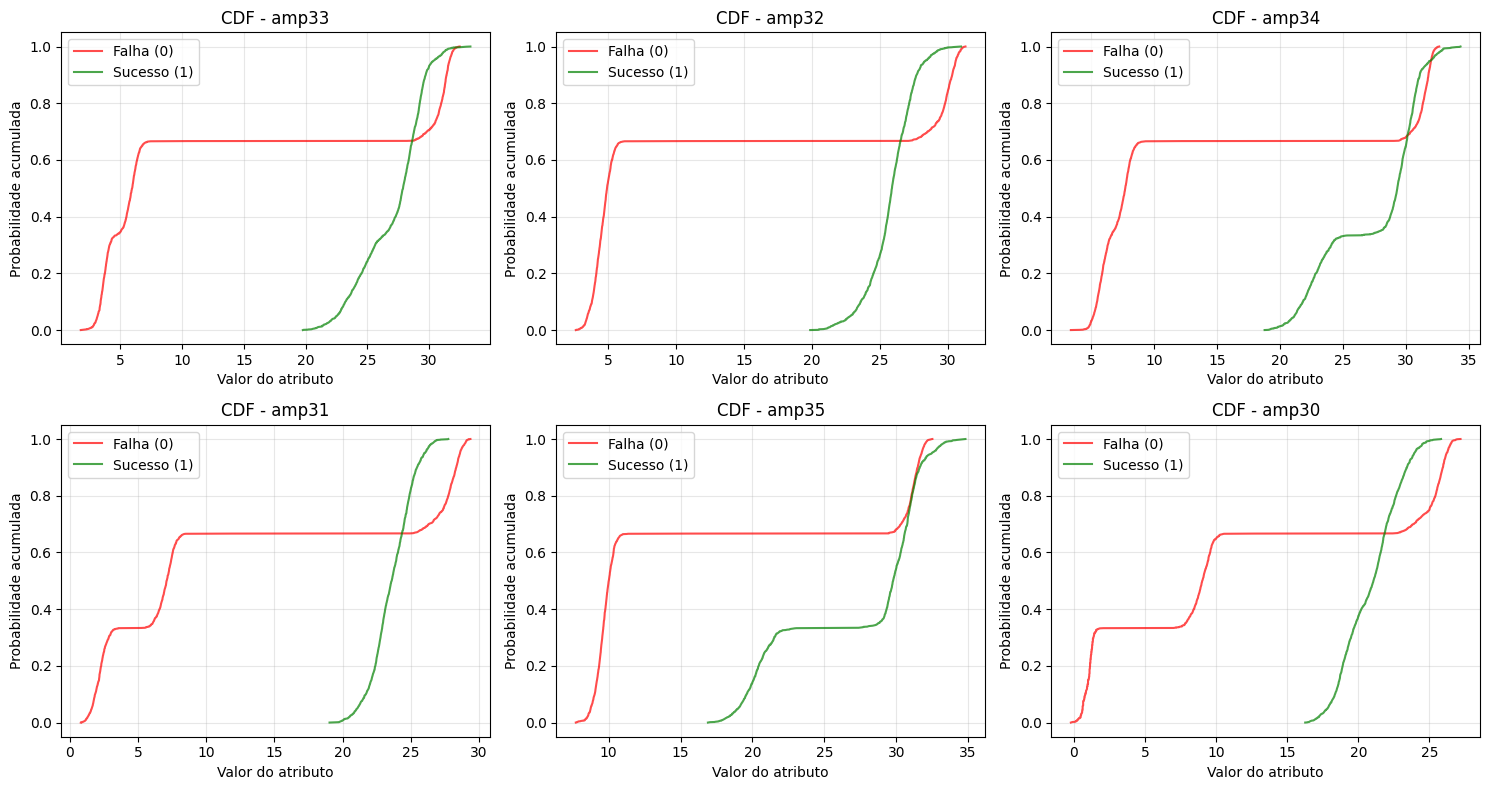

In [ ]:
#Função para calcular CDF empírica
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

#Criando grid de subplots (2 linhas × 3 colunas)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

#Plotando CDF para os melhores atributos (best_att)
for i, col in enumerate(best_att):
    ax = axes[i]
    
    #Dados separados por rótulo
    dados_falha = df_corr[df_corr['rotulo'] == 0][col]
    dados_sucesso = df_corr[df_corr['rotulo'] == 1][col]
    
    #Calcula CDF para falha
    x_f, y_f = ecdf(dados_falha)
    ax.plot(x_f, y_f, label="Falha (0)", color="red", alpha=0.7)
    
    #Calcula CDF para sucesso
    x_s, y_s = ecdf(dados_sucesso)
    ax.plot(x_s, y_s, label="Sucesso (1)", color="green", alpha=0.7)
    
    #Ajustes do gráfico
    ax.set_title(f"CDF - {col}", fontsize=12)
    ax.set_xlabel("Valor do atributo")
    ax.set_ylabel("Probabilidade acumulada")
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


## Importando bibliotecas e módulos para o treinamento de modelos

In [26]:
#Algoritmos de Machine Learning
from sklearn.tree import DecisionTreeClassifier                      #Árvores de decisão
from sklearn.neighbors import KNeighborsClassifier                   #kNN
from sklearn.naive_bayes import GaussianNB                           #Naive Bayes
from sklearn.svm import LinearSVC                                    #Máquinas de Vetores de Suporte
from sklearn.linear_model import SGDClassifier                       #Gradiente Estocástico
import joblib                                                        #Salvamento e carregamento de modelos

#Utilidades
from sklearn.preprocessing import StandardScaler                     #Normalização de atributos
import time                                                          #Tempo de execução
from pathlib import Path                                             #Caminhos de arquivos

#Avaliação e seleção de modelos
from sklearn.model_selection import (
    cross_val_score,                                                #Validação cruzada simples
    StratifiedKFold,                                                #Validação estratificada
    GridSearchCV,                                                   #Busca em grade de hiperparâmetros
)

#Métricas de avaliação
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,        #Métricas principais
    confusion_matrix, classification_report, ConfusionMatrixDisplay #Relatórios e matrizes
)

### Preparado conjunto de dados CSI para treinamento dos algoritmos de *Machine Learning*

Total: 4000 amostras de 10 pessoas (400 amostras por pessoa) $\rightarrow$ Conjunto universo (U) = 4000  
Conjunto de treinamento + Conjuto de teste= 3200 (8 pessoas)  
Amostra de validação = 800 (2 pessoas)

In [ ]:
#Construção de dados de treinamento e teste (Foram retirados 2 individuos de cada classe - 20% dos dados)
df_spider_sense = pd.read_csv("datasets/Spider-sense_3k_samples.csv")

#Selecionar apenas os atributos mais correlacionados com a classe alvo 
df_spider_sense_selected = df_spider_sense[best_att + ['rotulo']]

print(df_spider_sense_selected.head(), '\n')

#Preparação dos dados
X = df_spider_sense_selected.drop(columns=['rotulo'])      #Apenas atributos sem classe alvo
y = df_spider_sense_selected['rotulo']                     #Classe alvo

       amp33      amp32      amp34      amp31      amp35      amp30   rotulo
0  27.908109  25.856925  29.900920  22.555573  30.706497  18.494341  sucesso
1  27.931176  25.879325  29.686792  22.437266  30.445719  18.875093  sucesso
2  29.244921  27.173558  31.288166  23.606384  31.460959  19.848465  sucesso
3  29.928625  28.227017  32.062305  24.705798  31.995377  20.509192  sucesso
4  29.040501  27.068555  30.408620  23.859553  30.290360  19.520416  sucesso 



#### Treinamento com validação cruzada

- Padronização dos dados usando Z-score (pelo StandardScaler)
- Seleção dos melhores hiperparâmetros para cada algoritmo (pelo GridSearchCV)
- Treinamento usando a validação cruzada e a seleção do melhor modelo para cada algoritmo (pelo StratifieldKFold)

In [28]:
#Padronização dos dados CSI com média=0 e desvio_padrão=1 (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Definindo os modelos e hiperparâmetros
modelos_com_grid = {
    "Decision Tree": (DecisionTreeClassifier(random_state=42), {
        'max_depth': [3, 5, 7, None],
        'criterion': ['gini', 'entropy']
    }),
    "kNN": (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7]
    }),
    "Naive Bayes": (GaussianNB(), {}),
    "SVM Linear": (LinearSVC(random_state=42, dual=False, max_iter=10000), {
        'C': [0.1, 1, 10]
    })
}

#Definindo as validações (configuração nested CV)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#Avaliação de modelos
resultados_val = {}
melhor_modelo = None
melhor_nome = ""
melhor_acc = 0

output_dir = Path("results/cross-validation")
output_dir.mkdir(parents=True, exist_ok=True)

relatorio_path = output_dir / "relatorio.txt"

with open(relatorio_path, "w", encoding="utf-8") as f:
    f.write("Relatório da Validação Cruzada:\n\n")

    for nome, (modelo, grid) in modelos_com_grid.items():
        print(f"\nModel: {nome}")

        #Caso haja grid, usar GridSearchCV
        if grid:
            grid_search = GridSearchCV(modelo, grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        else:
            grid_search = modelo

        #Validação cruzada
        scores = cross_val_score(grid_search, X=X_scaled, y=y, cv=outer_cv, n_jobs=-1)
        resultados_val[nome] = scores

        #Treino final (melhor modelo) e medição de tempo
        start = time.perf_counter()
        grid_search.fit(X_scaled, y)
        end = time.perf_counter()
        tempo_treino = end - start

        final_model = grid_search.best_estimator_ if hasattr(grid_search, 'best_estimator_') else grid_search

        #Predição e avaliação do melhor modelo
        y_pred = final_model.predict(X_scaled)
        acc = accuracy_score(y, y_pred)

        #Relatório
        relatorio = classification_report(y, y_pred, target_names=["falha", "sucesso"], digits=4)
        f.write(f"Model: {nome}\n")
        f.write(f"Tempo de construção: {tempo_treino:.6f} segundos\n")
        f.write(relatorio)
        f.write("\n" + "-" * 60 + "\n")

        print(relatorio)
        print(f"Tempo de construção do modelo: {tempo_treino:.6f} segundos")

        #Atualização do melhor modelo
        if acc > melhor_acc:
            melhor_acc = acc
            melhor_modelo = final_model
            melhor_nome = nome


Model: Decision Tree
              precision    recall  f1-score   support

       falha     0.9973    0.9993    0.9983      1500
     sucesso     0.9993    0.9973    0.9983      1500

    accuracy                         0.9983      3000
   macro avg     0.9983    0.9983    0.9983      3000
weighted avg     0.9983    0.9983    0.9983      3000

Tempo de construção do modelo: 0.080986 segundos

Model: kNN
              precision    recall  f1-score   support

       falha     1.0000    1.0000    1.0000      1500
     sucesso     1.0000    1.0000    1.0000      1500

    accuracy                         1.0000      3000
   macro avg     1.0000    1.0000    1.0000      3000
weighted avg     1.0000    1.0000    1.0000      3000

Tempo de construção do modelo: 0.037458 segundos

Model: Naive Bayes
              precision    recall  f1-score   support

       falha     0.9712    0.7407    0.8404      1500
     sucesso     0.7904    0.9780    0.8743      1500

    accuracy                  

#### Matriz de confusão do melhor classificador

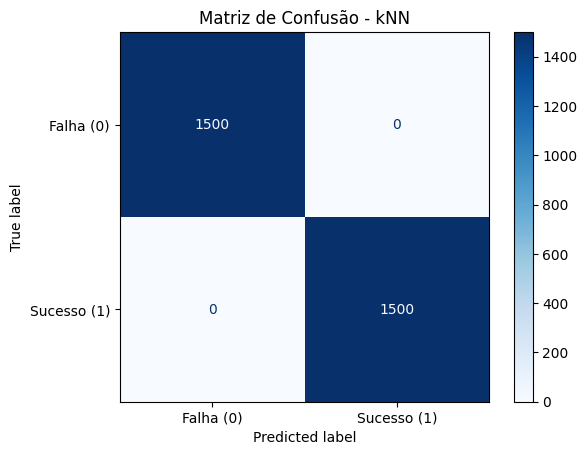

In [29]:
#Predição com o melhor modelo encontrado
y_pred_final = melhor_modelo.predict(X_scaled)

#Matriz de confusão
cm = confusion_matrix(y, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Falha (0)", "Sucesso (1)"])
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Matriz de Confusão - {melhor_nome}")
plt.show()
